In [214]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping


In [215]:
# 载入数据
file_path = 'Database_4c.xlsx'
data = pd.read_excel(file_path)


In [216]:
print(data.columns)

Index(['x1', 'x2', 'x3', 'y1', 'y2', 'y3', 'y_2'], dtype='object')


In [217]:
# 特征和标签
X = data[['x1', 'x2', 'x3']].values
# y_spin = data[['y1', 'y2', 'y3']].values
y1_spin = data['y1'].values
y2_spin = data['y2'].values
y3_spin = data['y3'].values
y_wavelength = to_categorical(data['y_2'].values - 1, num_classes=7)  # 减1是因为to_categorical从0开始索引



In [218]:
# 拆分数据集
X_train, X_test, y1_spin_train, y1_spin_test, y2_spin_train, y2_spin_test, y3_spin_train, y3_spin_test, y_wavelength_train, y_wavelength_test = train_test_split(
    X, y1_spin, y2_spin, y3_spin, y_wavelength, test_size=0.2, random_state=42)# stratify=y_wavelength.argmax(axis=1)


# 模型构建
input_layer = Input(shape=(X.shape[1],))
hidden_layer_1 = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(input_layer)
drop_out = Dropout(0.5)(hidden_layer_1)
hidden_layer_2 = Dense(128, activation='relu')(hidden_layer_1)
drop_out = Dropout(0.5)(hidden_layer_2)
hidden_layer_3 = Dense(64, activation='relu')(hidden_layer_2)
drop_out = Dropout(0.5)(hidden_layer_3)
hidden_layer_4 = Dense(64, activation='relu')(hidden_layer_3)

bn = BatchNormalization()(hidden_layer_4)
hidden_layer_5 = Dense(64, activation='relu')(bn)

# Spin预测
spin1_output = Dense(1, activation='sigmoid', name='spin1_output', kernel_regularizer=l2(0.0001))(hidden_layer_4)
spin2_output = Dense(1, activation='sigmoid', name='spin2_output', kernel_regularizer=l2(0.0001))(hidden_layer_5)
spin3_output = Dense(1, activation='sigmoid', name='spin3_output', kernel_regularizer=l2(0.0001))(hidden_layer_2)

  # Wavelength预测
wavelength_output = Dense(y_wavelength.shape[1], activation='softmax', name='wavelength_output')(hidden_layer_5)  # Wavelength预测



In [219]:
# 创建模型
model = Model(inputs=input_layer, outputs=[spin1_output, spin2_output, spin3_output, wavelength_output])

# 损失函数：前三个输出用二元交叉熵，最后一个输出用分类交叉熵
losses = {
    'spin1_output': 'binary_crossentropy',
    'spin2_output': 'binary_crossentropy',
    'spin3_output': 'binary_crossentropy',
    'wavelength_output': 'categorical_crossentropy'
}

# 编译模型
model.compile(optimizer=Adam(), loss=losses, metrics=['accuracy'])



In [220]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [221]:
# 训练模型
model.fit(X_train, [y1_spin_train,y2_spin_train, y3_spin_train, y_wavelength_train], 
          validation_data=(X_test, [y1_spin_test,y2_spin_test,y3_spin_test, y_wavelength_test]), 
          epochs=100, 
          batch_size=32)


Epoch 1/100


14/14 [==============================] - 2s 41ms/step - loss: 3.7738 - spin1_output_loss: 0.6929 - spin2_output_loss: 0.6375 - spin3_output_loss: 0.6932 - wavelength_output_loss: 1.7438 - spin1_output_accuracy: 0.5179 - spin2_output_accuracy: 0.6674 - spin3_output_accuracy: 0.5357 - wavelength_output_accuracy: 0.3348 - val_loss: 3.9969 - val_spin1_output_loss: 0.6919 - val_spin2_output_loss: 0.6893 - val_spin3_output_loss: 0.6925 - val_wavelength_output_loss: 1.9170 - val_spin1_output_accuracy: 0.5625 - val_spin2_output_accuracy: 0.6429 - val_spin3_output_accuracy: 0.5446 - val_wavelength_output_accuracy: 0.2679
Epoch 2/100
14/14 [==============================] - 0s 13ms/step - loss: 3.3233 - spin1_output_loss: 0.6932 - spin2_output_loss: 0.5518 - spin3_output_loss: 0.6921 - wavelength_output_loss: 1.3798 - spin1_output_accuracy: 0.5134 - spin2_output_accuracy: 0.7478 - spin3_output_accuracy: 0.5670 - wavelength_output_accuracy: 0.5089 - val_loss: 3.9511 - val_spin1_output_loss: 0.692

In [222]:
# print the training loss and accuracy
training_history = model.history
print('Training Loss:', min(training_history.history['loss']))
# print the minimum training loss
# print('Minimum Training Loss:', min(history.history['loss']))

training_spin_loss = (min(training_history.history['spin1_output_loss']) + min(training_history.history['spin2_output_loss']) + min(training_history.history['spin3_output_loss']))/3
print('Training Spin Loss:', training_spin_loss)
print('Training Wavelength Loss:', min(training_history.history['wavelength_output_loss']))

training_spin_acc = (max(training_history.history['spin1_output_accuracy']) + max(training_history.history['spin2_output_accuracy']) + max(training_history.history['spin3_output_accuracy']))/3
print('Training Spin Accuracy:', training_spin_acc)
print('Training Wavelength Accuracy:', max(training_history.history['wavelength_output_accuracy']))


#ptint the minimum validation loss
print('Minimum Test Loss:', min(training_history.history['val_loss']))
val_spin_loss = (min(training_history.history['val_spin1_output_loss']) + min(training_history.history['val_spin2_output_loss']) + min(training_history.history['val_spin3_output_loss']))/3
print('Val Spin Loss:', val_spin_loss)
print('Val Wavelength Loss:', min(training_history.history['val_wavelength_output_loss']))


Val_spin_acc = (max(training_history.history['val_spin1_output_accuracy']) + max(training_history.history['val_spin2_output_accuracy']) + max(training_history.history['val_spin3_output_accuracy']))/3
print('Val Spin Accuracy:', Val_spin_acc)
print('Val Wavelength Accuracy:', max(training_history.history['val_wavelength_output_accuracy']))


Training Loss: 1.259039044380188
Training Spin Loss: 0.32951908310254413
Training Wavelength Loss: 0.23790118098258972
Training Spin Accuracy: 0.8273809552192688
Training Wavelength Accuracy: 0.9084821343421936
Minimum Test Loss: 1.6930599212646484
Val Spin Loss: 0.3284507319331169
Val Wavelength Loss: 0.5859633684158325
Val Spin Accuracy: 0.8333333532015482
Val Wavelength Accuracy: 0.8035714030265808


In [223]:
# evaluate the model
loss, spin1_loss, spin2_loss, spin3_loss,  wavelength_loss, spin1_accuracy, spin2_acc, spin3_acc, wavelength_accuracy = model.evaluate(X_test, [y1_spin_test, y2_spin_test, y3_spin_test, y_wavelength_test])
print('Loss:', loss)
spin_loss = (spin1_loss + spin2_loss + spin3_loss) / 3

print('Spin Loss:', spin_loss)
print('Wavelength Loss:', wavelength_loss)
spin_acc = (spin1_accuracy + spin2_acc + spin3_acc) / 3
print('Spin Accuracy:', spin_acc)
print('Spin1 Accuracy:', spin1_accuracy)
print('Spin2 Accuracy:', spin2_acc)
print('Spin3 Accuracy:', spin3_acc)
print('Wavelength Accuracy:', wavelength_accuracy)




4/4 [==============================] - 0s 2ms/step - loss: 1.7299 - spin1_output_loss: 0.3369 - spin2_output_loss: 0.1689 - spin3_output_loss: 0.5633 - wavelength_output_loss: 0.6441 - spin1_output_accuracy: 0.7857 - spin2_output_accuracy: 0.9018 - spin3_output_accuracy: 0.6964 - wavelength_output_accuracy: 0.7946
Loss: 1.7298948764801025
Spin Loss: 0.35638225575288135
Wavelength Loss: 0.6441081166267395
Spin Accuracy: 0.7946428656578064
Spin1 Accuracy: 0.7857142686843872
Spin2 Accuracy: 0.9017857313156128
Spin3 Accuracy: 0.6964285969734192
Wavelength Accuracy: 0.7946428656578064


In [224]:
model.summary()
# draw the model

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_0419.png', show_shapes=True)

# save the model
model.save('model_0419.h5')  


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 3)]                  0         []                            
                                                                                                  
 dense_35 (Dense)            (None, 64)                   256       ['input_8[0][0]']             
                                                                                                  
 dense_36 (Dense)            (None, 128)                  8320      ['dense_35[0][0]']            
                                                                                                  
 dense_37 (Dense)            (None, 64)                   8256      ['dense_36[0][0]']            
                                                                                            

/home/guoguo/anaconda3/envs/photocurrent/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


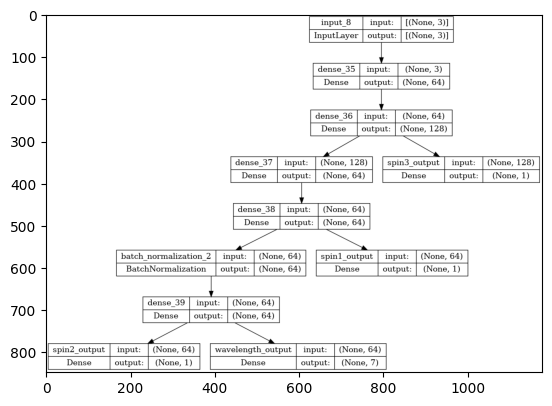

In [225]:
# draw the model structure
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
img = plt.imread('model.png')
plt.imshow(img)
plt.show()


In [226]:
# draw the accuracy of the model
from sklearn.metrics import accuracy_score

y_pred_w = model.predict(X_test)[3] # 取出Wavelength的预测结果
y_pred_w = np.argmax(y_pred_w, axis=1) + 1  # 取出最大值的索引，加1是因为to_categorical从0开始索引
y_true_w = np.argmax(y_wavelength_test, axis=1) + 1

accuracy = accuracy_score(y_true_w, y_pred_w)
print('Accuracy:', accuracy)




4/4 [==============================] - 0s 10ms/step
Accuracy: 0.7946428571428571


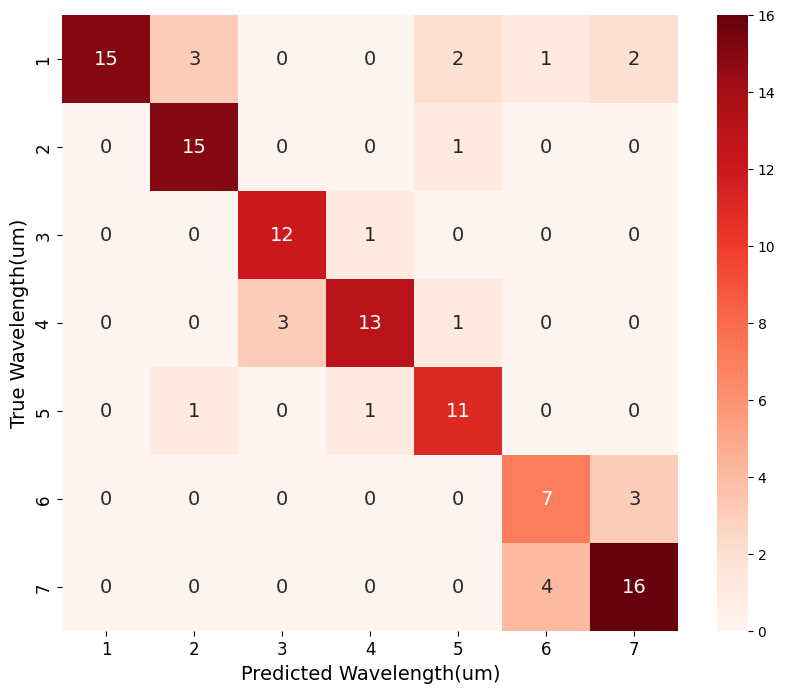

In [227]:
# draw the confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(10, 8))
confusion = confusion_matrix(y_true_w, y_pred_w)
sns.heatmap(confusion, annot=True, fmt='d', cmap='Reds', square=True, annot_kws={"size": 14})
# chaneg the x,y from 1-7
plt.xticks(np.arange(7) + 0.5, range(1, 8), fontsize=12)
plt.yticks(np.arange(7) + 0.5, range(1, 8), fontsize=12)
# add the unit（um） of x,y axis

plt.xlabel('Predicted Wavelength(um)', fontsize=14)
plt.ylabel('True Wavelength(um)', fontsize=14)
# plt.gca().invert_yaxis()
plt.show()





4/4 [==============================] - 0s 1ms/step


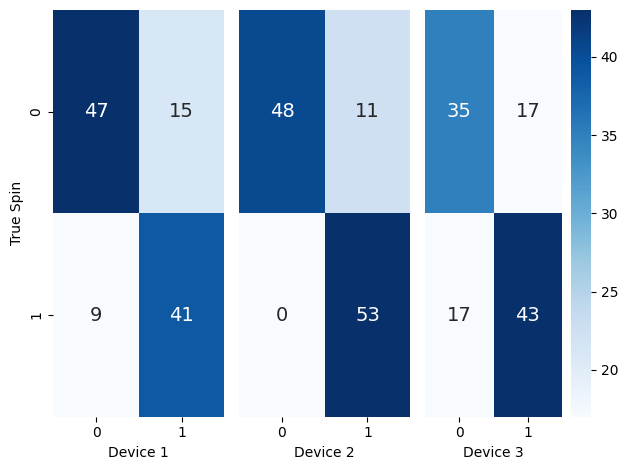

In [228]:
# draw the confusion matrix of spin1, spin2, spin3 together

y_pred_s1 = model.predict(X_test)[0]  # 取出spin1的预测结果
y_pred_s1 = np.round(y_pred_s1).flatten()
y_true_s1 = y1_spin_test

y_pred_s2 = model.predict(X_test)[1]  # 取出spin2的预测结果
y_pred_s2 = np.round(y_pred_s2).flatten()
y_true_s2 = y2_spin_test

y_pred_s3 = model.predict(X_test)[2]  # 取出spin3的预测结果
y_pred_s3 = np.round(y_pred_s3).flatten()
y_true_s3 = y3_spin_test

fig = plt.figure()
plt.subplot(1, 3, 1)
confusion_s1 = confusion_matrix(y_true_s1, y_pred_s1)
sns.heatmap(confusion_s1, annot=True, fmt='d', cbar=False, cmap='Blues',annot_kws={"size": 14})
plt.xlabel('Device 1')
plt.ylabel('True Spin')

plt.subplot(1, 3, 2)
confusion_s2 = confusion_matrix(y_true_s2, y_pred_s2)
sns.heatmap(confusion_s2, annot=True, fmt='d', cbar=False, cmap='Blues', annot_kws={"size": 14}) # cmap='Blues'
plt.xlabel('Device 2')
plt.ylabel('')
plt.yticks([])

plt.subplot(1, 3, 3)
confusion_s3 = confusion_matrix(y_true_s3, y_pred_s3)
sns.heatmap(confusion_s3, annot=True, fmt='d', cmap='Blues',annot_kws={"size": 14})
plt.xlabel('Device 3')
plt.ylabel('')
plt.yticks([])
plt.tight_layout()
plt.show()

4/4 [==============================] - 0s 1ms/step


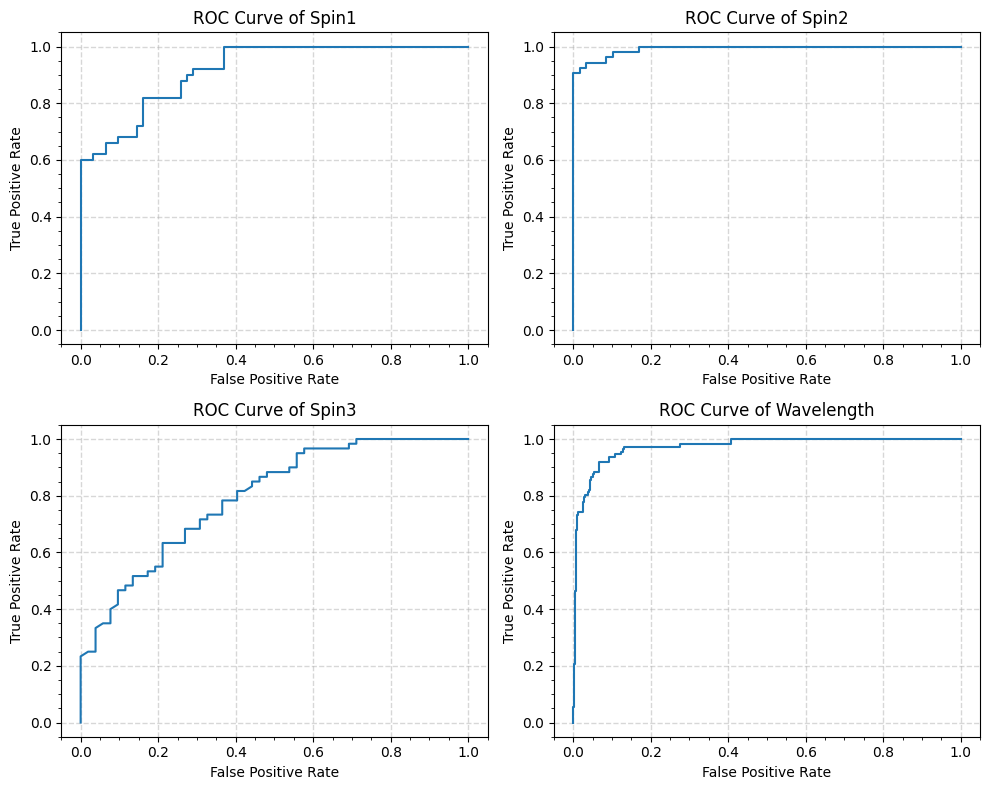

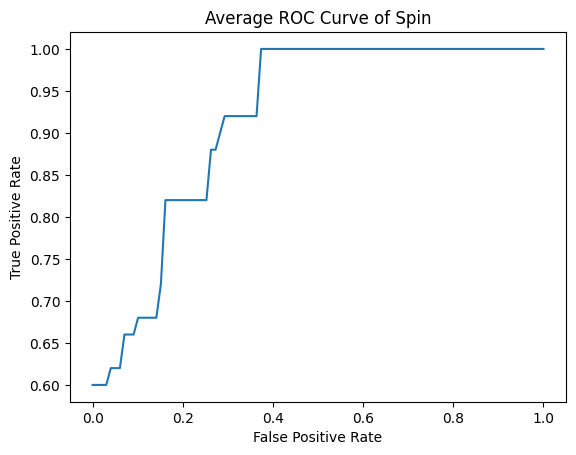

In [229]:
# draw the ROC curve of the model for spin1, spin2, spin3 and wavelength together
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

y_pred_s1 = model.predict(X_test)[0]  # 取出spin1的预测结果
y_pred_s1 = y_pred_s1.flatten()
y_true_s1 = y1_spin_test

y_pred_s2 = model.predict(X_test)[1]  # 取出spin2的预测结果
y_pred_s2 = y_pred_s2.flatten()
y_true_s2 = y2_spin_test

y_pred_s3 = model.predict(X_test)[2]  # 取出spin3的预测结果
y_pred_s3 = y_pred_s3.flatten()
y_true_s3 = y3_spin_test

y_pred_w = model.predict(X_test)[3]  # 取出Wavelength的预测结果
y_pred_w = y_pred_w.flatten()
y_true_w = np.argmax(y_wavelength_test, axis=1)

fig = plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
fpr, tpr, thresholds = roc_curve(y_true_s1, y_pred_s1)
plt.plot(fpr, tpr)
plt.grid(linestyle='--', linewidth=1, alpha=0.5)
plt.minorticks_on()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Spin1')

plt.subplot(2, 2, 2)
fpr, tpr, thresholds = roc_curve(y_true_s2, y_pred_s2)
plt.plot(fpr, tpr)
plt.grid(linestyle='--', linewidth=1, alpha=0.5)
plt.minorticks_on()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Spin2')

plt.subplot(2, 2, 3)
fpr, tpr, thresholds = roc_curve(y_true_s3, y_pred_s3)
plt.plot(fpr, tpr)
plt.grid(linestyle='--', linewidth=1, alpha=0.5)
plt.minorticks_on()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Spin3')

plt.subplot(2, 2, 4)
fpr, tpr, thresholds = roc_curve(y_wavelength_test.ravel(), y_pred_w.ravel())
plt.plot(fpr, tpr)
plt.grid(linestyle='--', linewidth=1, alpha=0.5)
plt.minorticks_on()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Wavelength')

plt.tight_layout()
plt.show()

# draw the average ROC curve of the model
avg_fpr = np.linspace(0, 1, 100)
tprs = []
for i in range(3):
    fpr, tpr, thresholds = roc_curve(y_true_s1, y_pred_s1)
    tprs.append(np.interp(avg_fpr, fpr, tpr))
tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
plt.plot(avg_fpr, mean_tprs)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Average ROC Curve of Spin')
plt.show()






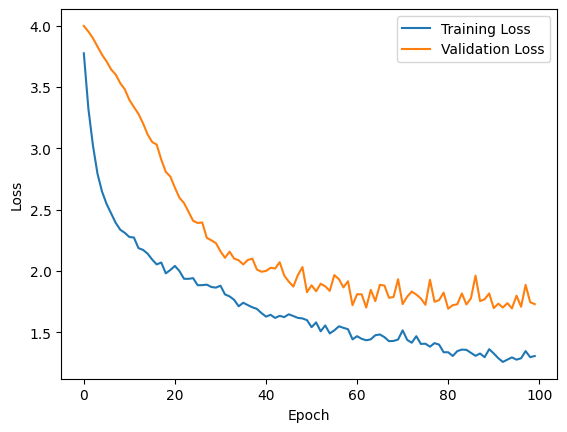

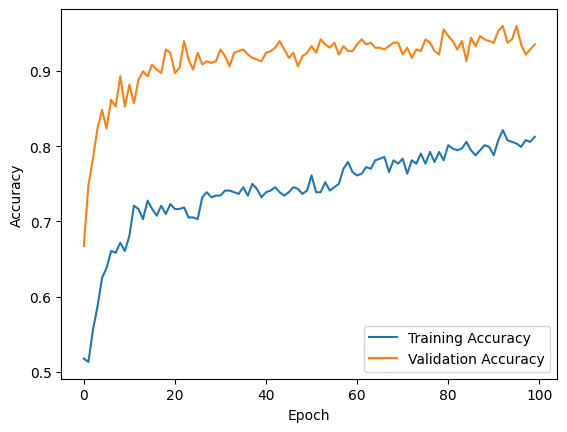

In [230]:
# plot the training loss of the model
import matplotlib.pyplot as plt
plt.plot(training_history.history['loss'], label='Training Loss')
plt.plot(training_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot the training spin1 accuracy of the model
plt.plot(training_history.history['spin1_output_accuracy'], label='Training Accuracy')
plt.plot(training_history.history['spin2_output_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()    
